### Imports

In [81]:
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
import numpy as np

from sklearn.cluster import KMeans
from sklearn.feature_extraction import FeatureHasher
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

### Load data

In [82]:
df = pd.read_parquet('preprocessing/data/Final.parquet') # Adjust depending on the path of the file
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18782364 entries, 0 to 18782363
Data columns (total 19 columns):
 #   Column                Dtype  
---  ------                -----  
 0   OrderNumber           string 
 1   Company               string 
 2   ArticleID             int64  
 3   OrderDate             int64  
 4   CustomerID            string 
 5   RevenueType           string 
 6   PricePackagingUnit    float64
 7   Quantity              float64
 8   NetRevenue            float64
 9   ProductGroup          string 
 10  ProductSubgroup       string 
 11  BusinessArea          string 
 12  Type                  string 
 13  PostalCode            object 
 14  IndustryGroup         string 
 15  SalesChannelCategory  string 
 16  SalesChannel          string 
 17  State                 object 
 18  City                  object 
dtypes: float64(3), int64(2), object(3), string(11)
memory usage: 2.7+ GB
None


### Add features

In [83]:
df['OrderDate'] = pd.to_datetime(df['OrderDate'], format='%Y%m%d')

# Add column for season
def season_from_month(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Autumn'
    else:
        return 'Unknown'
    
df['Season'] = df['OrderDate'].dt.month.apply(season_from_month)
df = df[df['OrderDate'].dt.year == 2023]


### Generate Sample (run again from this point to reduce loading times, and generate new random samples)

In [84]:
df_sample = df.sample(100000)

In [85]:
totalRevenue = df_sample['NetRevenue'].sum()
print(totalRevenue)

result = df_sample.groupby('CustomerID')['NetRevenue'].sum().reset_index()
result['shareOfRevenue'] = (result['NetRevenue']/totalRevenue)*100
result = result.sort_values('shareOfRevenue', ascending=False)
print(result.head())
#print(result['shareOfRevenue'].sum())

result["cumulatedShare"] = np.cumsum(result["shareOfRevenue"])
print(result.head())

542556.8992146597
      CustomerID   NetRevenue  shareOfRevenue
2299      151238  5452.641361        1.004990
10871    9207255  5446.376963        1.003835
7128     5342710  4812.706806        0.887042
764     10413532  4811.438482        0.886808
5311        4619  4701.232984        0.866496
      CustomerID   NetRevenue  shareOfRevenue  cumulatedShare
2299      151238  5452.641361        1.004990        1.004990
10871    9207255  5446.376963        1.003835        2.008825
7128     5342710  4812.706806        0.887042        2.895867
764     10413532  4811.438482        0.886808        3.782675
5311        4619  4701.232984        0.866496        4.649171


### Create sample with 3 RFM features

In [86]:
rfm = pd.DataFrame()

# timespan since most recent order per customer
reference_time = pd.Timestamp('2023-12-31')
reference_date = pd.to_datetime(reference_time, format='%Y%m%d')
# Calculate the difference in days from the reference date
df_sample['DaysSinceLastOrder'] = (reference_date - df_sample['OrderDate']).dt.days
# Find the most recent order in weeks for each customerID
rfmrec = df_sample.groupby('CustomerID')['DaysSinceLastOrder'].min().reset_index()

# count of orders per customer
# tbd count on order level? i.e., count only the unique order numbers?
rfmfreq = df_sample['CustomerID'].value_counts().reset_index()
rfmfreq.columns = ['CustomerID', 'orderCount']

# total revenue per customer
rfmmon = df_sample.groupby('CustomerID')['NetRevenue'].sum().reset_index()
rfmmon.columns = ['CustomerID', 'sumRevenue']

# merge features
rfm1 = pd.merge(rfmrec, rfmfreq, on='CustomerID')
rfm = pd.merge(rfm1, rfmmon, on='CustomerID')
df_sample =df_sample.drop(['DaysSinceLastOrder'], axis=1)

rfm.head()

,CustomerID,DaysSinceLastOrder,orderCount,sumRevenue
0,10001245,18,29,129.285340
1,10001255,97,2,3.664921
2,10002752,146,4,21.153141
3,10003783,41,1,2.905759
4,10003830,95,5,52.206806


### Apply K-means and find best cluster

In [87]:
rfm_num = rfm[["DaysSinceLastOrder", "orderCount", "sumRevenue"]]
scaler = StandardScaler()
scaled_rfm = scaler.fit_transform(rfm_num)

# scale
rfm_scaled = pd.DataFrame(scaled_rfm, columns=rfm_num.columns)
print(rfm_scaled.head())

cluster_scores = []

# apply K-Means Clustering
for i in range(2, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    clusters = kmeans.fit_predict(rfm_scaled)
    score = silhouette_score(rfm_scaled, clusters)
    cluster_scores.append((i, score))
    print(f"Silhouette Score for {i} clusters: {score}")

# Get best cluster number
best_cluster = max(cluster_scores, key=lambda x: x[1])[0]
print(f"Best cluster number: {best_cluster}")

   DaysSinceLastOrder  orderCount  sumRevenue
0           -0.946955    0.797836    0.566250
1           -0.165096   -0.233402   -0.267868
2            0.319854   -0.157014   -0.151747
3           -0.719325   -0.271596   -0.272909
4           -0.184890   -0.118820    0.054450
Silhouette Score for 2 clusters: 0.5196965455109478
Silhouette Score for 3 clusters: 0.5238547622735907
Silhouette Score for 4 clusters: 0.5575554213787035
Silhouette Score for 5 clusters: 0.5701478561214819
Silhouette Score for 6 clusters: 0.5533194526470453
Silhouette Score for 7 clusters: 0.4912536386091991
Silhouette Score for 8 clusters: 0.4997316907346409
Silhouette Score for 9 clusters: 0.5079637411653897
Silhouette Score for 10 clusters: 0.4670115476519497
Best cluster number: 5


In [88]:
k_means_optimum = KMeans(n_clusters=best_cluster, init='k-means++', random_state=42)
y = k_means_optimum.fit_predict(rfm_scaled)

rfm['cluster'] = y

for i in range(best_cluster):
  # Create dataframe for each cluster
  globals()[f'data{i}'] = rfm[rfm.cluster == i]

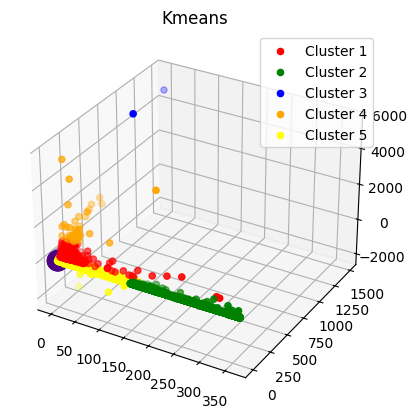

In [89]:
kplot = plt.axes(projection='3d')
xline = np.linspace(0, 15, 1000)
yline = np.linspace(0, 15, 1000)
zline = np.linspace(0, 15, 1000)

kplot.plot3D(xline, yline, zline, 'black')

colors = ['red', 'green', 'blue', 'orange', 'yellow', 'purple', 'pink', 'brown', 'grey', 'cyan', 'magenta']

for i in range(best_cluster):
  globals()[f'data{i}'] = rfm[rfm.cluster == i]
  kplot.scatter3D(globals()[f'data{i}']['DaysSinceLastOrder'], globals()[f'data{i}']['orderCount'], globals()[f'data{i}']['sumRevenue'], c=colors[i], label = f'Cluster {i+1}')
plt.scatter(k_means_optimum.cluster_centers_[:,0], k_means_optimum.cluster_centers_[:,1], color = 'indigo', s = 200)
plt.legend()
plt.title("Kmeans")
plt.show()